In [1]:
import imprint.nb_util as nb_util
nb_util.setup_nb()

import time
import jax
import jax.numpy as jnp
from jax.scipy.special import expit, logit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import confirm.models.wd41 as wd41
import imprint as ip

## Exploring

We have two subgroups, each split equally into treatment and control arms:
- $p_{\mathrm{TNBC}}^{c}$ - TNBC subgroup control arm effectiveness.
- $p_{\mathrm{TNBC}}^{t}$ - TNBC subgroup treatment arm effectiveness.
- $p_{\mathrm{HR+}}^{c}$ - HR+ subgroup control arm effectiveness.
- $p_{\mathrm{HR+}}^{t}$ - HR+ subgroup treatment arm effectiveness.
  
$f_{\mathrm{TNBC}}$ is the fraction of patients in the TNBC subgroup.

The null hypotheses here are:

$$
p_{\mathrm{TNBC}}^{c} > p_{\mathrm{TNBC}}^{t}
$$

$$
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{c} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{c} > 
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{t} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{t}
$$

Adaptive Dunnett tests for treatment selection: https://pubmed.ncbi.nlm.nih.gov/17876763/

In [2]:
m = wd41.WD41(0, 1, ignore_intersection=True)

In [3]:
p_tnbc_c = 0.34
p_hrplus_c = 0.23
S = np.linspace(0, 0.3, 7)
Sbar = np.linspace(0, 0.2, 3)
SS = np.stack(np.meshgrid(S, Sbar, indexing='ij'), axis=-1).reshape(-1, 2)
t_tnbc_t = logit(p_tnbc_c + SS[:, 0])
t_tnbc_c = np.full_like(t_tnbc_t, logit(p_tnbc_c))
t_hrplus_t = logit(p_hrplus_c + SS[:, 1])
t_hrplus_c = np.full_like(t_hrplus_t, logit(p_hrplus_c))
theta = np.stack((t_tnbc_c, t_tnbc_t, t_hrplus_c, t_hrplus_t), axis=-1)

In [6]:
K = 300000
np.random.seed(0)
unifs = np.random.uniform(size=(K, m.unifs.shape[1]))
info = m.sim_jit(unifs, theta, True)

In [7]:
lam = 0.014290583
df = pd.DataFrame(SS, columns=['Effect S', 'Effect Sbar'])
df['Effect F'] = 0.54 * df['Effect S'] + 0.46 * df['Effect Sbar']
df['Power'] = np.sum((info['tnbc_stat'] < lam) | (info['full_stat'] < lam), axis=1) / K
df['P(Reject F)'] = np.sum(info['full_stat'] < lam, axis=1) / K
df['P(Reject S)'] = np.sum(info['tnbc_stat'] < lam, axis=1) / K
df['P(Select F)'] = np.sum(info['hypofull_live'], axis=1) / K
df['P(Select S)'] = np.sum(info['hypotnbc_live'], axis=1) / K
df['P(Select 1 set)'] = np.sum((~info['hypotnbc_live']) | (~info['hypofull_live']), axis=1) / K
df['P(Enrichment)'] = 1 - df['P(Select F)']
df.set_index(np.arange(1, 22), inplace=True)
df

,Effect S,Effect Sbar,Effect F,Power,P(Reject F),P(Reject S),P(Select F),P(Select S),P(Select 1 set),P(Enrichment)
1,0.00,0.0,0.000,0.023013,0.012547,0.014457,0.931500,0.931170,0.137330,0.068500
2,0.00,0.1,0.046,0.093133,0.088737,0.014667,0.982357,0.781827,0.235817,0.017643
3,0.00,0.2,0.092,0.304807,0.303830,0.014617,0.996630,0.545353,0.458017,0.003370
4,0.05,0.0,0.027,0.087733,0.036850,0.068687,0.872020,0.964853,0.163127,0.127980
5,0.05,0.1,0.073,0.209830,0.188920,0.065027,0.960640,0.863920,0.175440,0.039360
6,0.05,0.2,0.119,0.485680,0.480830,0.063623,0.991410,0.667693,0.340897,0.008590
7,0.10,0.0,0.054,0.240823,0.084100,0.211123,0.786010,0.983540,0.230450,0.213990
8,0.10,0.1,0.100,0.392097,0.326340,0.196693,0.922493,0.921460,0.156047,0.077507
9,0.10,0.2,0.146,0.670267,0.653293,0.190757,0.979460,0.773887,0.246653,0.020540
10,0.15,0.0,0.081,0.479480,0.149610,0.447557,0.675677,0.993027,0.331297,0.324323


In [12]:
df_compare = pd.read_csv('wd41.csv', index_col=0)

In [13]:
df['Power'] - df_compare['Power']

1     0.007613
2     0.031263
3     0.066207
4     0.021773
5     0.058600
6     0.087640
7     0.043033
8     0.079757
9     0.089387
10    0.062550
11    0.083437
12    0.069030
13    0.063723
14    0.063470
15    0.039537
16    0.043043
17    0.034860
18    0.017937
19    0.019057
20    0.013977
21    0.005453
Name: Power, dtype: float64

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000


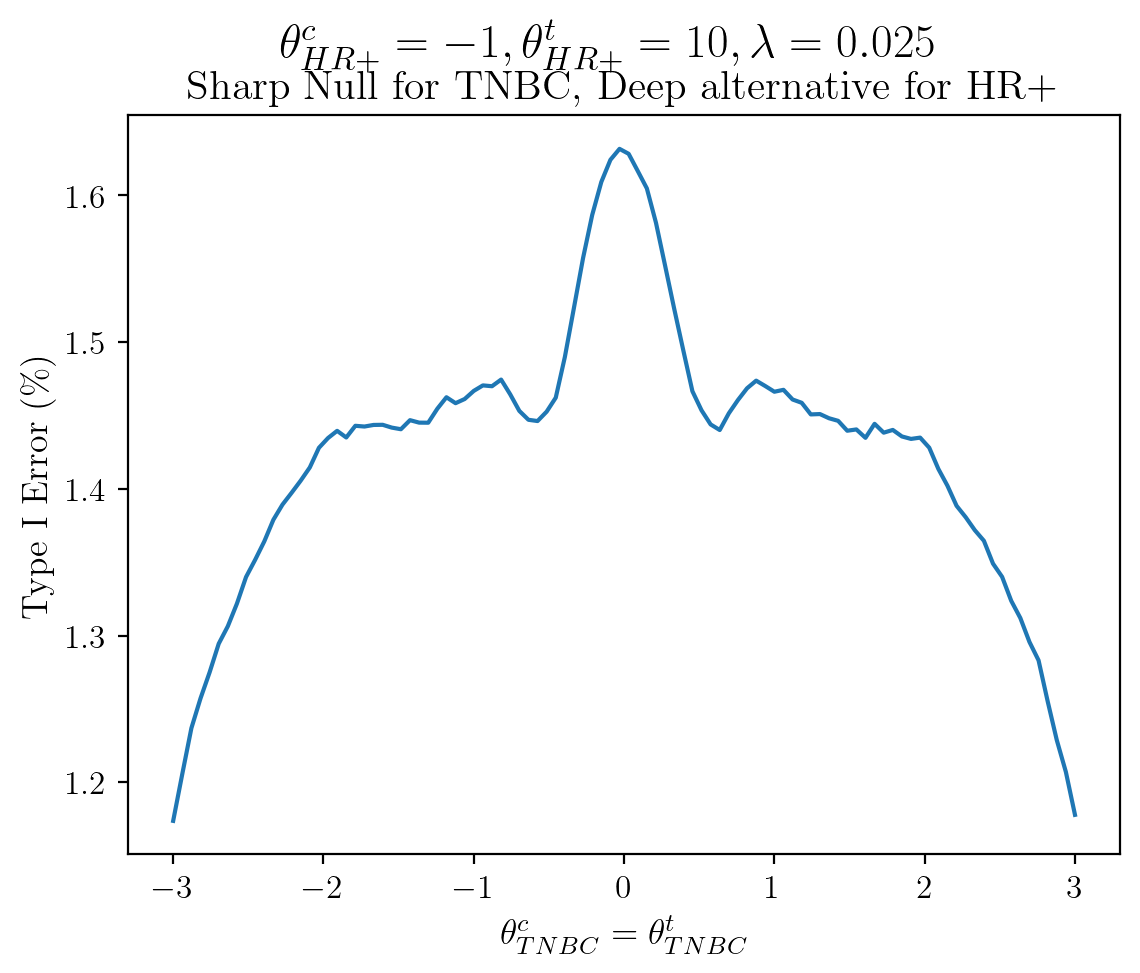

In [8]:
theta0 = np.linspace(-3, 3, 100)
theta1 = theta0
theta2 = np.full_like(theta0, -1)
theta3 = np.full_like(theta0, 10)
theta = np.stack((theta0, theta1, theta2, theta3), axis=-1)
nt0 = np.ones_like(theta0)
nt1 = np.zeros_like(theta0)
null_truth = np.stack((nt0, nt1), axis=-1)

tie_sum = np.zeros_like(theta0)
nsims = 0
for i in range(50):
    unifs = np.random.random(size=(100000, m.unifs.shape[1]))
    stats, _ = m.sim_jit(unifs, theta, False)
    tie_sum += (stats < lam).sum(axis=1)
    nsims += unifs.shape[0]
    print(nsims)

tie_est = tie_sum / nsims
plt.plot(theta0, 100 * tie_est)
plt.xlabel(r'$\theta_{TNBC}^c = \theta_{TNBC}^t$')
plt.ylabel('Type I Error (\%)')
plt.title(r'Sharp Null for TNBC, Deep alternative for HR+')
plt.suptitle(r'$\theta_{HR+}^c = -1, \theta_{HR+}^t = 10, \lambda = 0.025$')
plt.show()

## Simple grids

In [3]:
theta_tnbc_c = -1
p_tnbc_c = expit(theta_tnbc_c)
theta_hrplus_c = -1
p_hrplus_c = expit(theta_hrplus_c)


def get_theta(theta):
    t_tnbc_t = theta[..., 0]
    return jnp.stack(
        (
            jnp.full_like(t_tnbc_t, theta_tnbc_c),
            t_tnbc_t,
            jnp.full_like(t_tnbc_t, theta_hrplus_c),
            theta[..., 1],
        ),
        axis=-1,
    )


class WD41Null2D(wd41.WD41Null):
    def get_theta(self, theta):
        return get_theta(theta)


class WD412D(wd41.WD41):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.family_params = {
            "n": jnp.array(
                [
                    self.n_max_tnbc,
                    self.n_max_hrplus,
                ]
            )
        }

    def sim_batch(
        self,
        begin_sim: int,
        end_sim: int,
        theta: jnp.ndarray,
        null_truth: jnp.ndarray,
        detailed: bool = False,
    ):
        return super().sim_batch(
            begin_sim,
            end_sim,
            get_theta(theta),
            null_truth,
            detailed,
        )

In [4]:
model = WD412D(0, 100000, ignore_intersection=True)
nulls = [ip.hypo("-1 > theta0"), WD41Null2D(model.true_frac_tnbc)]

In [24]:
grid = ip.cartesian_grid([-2.5, -2.5], [-0.0, -0.0], n=[90, 90], null_hypos=nulls)

val_df = ip.validate(WD412D, g=grid, lam=lam, K=10000, model_kwargs={'ignore_intersection': True})

DEBUG:imprint.grid:[worker_id=2] 
_gen_short_uuids(n=8100, worker_id=1, t=1677614468, n_bits=18, worker_bits=18) = [4604323963445968896 4604323963445968897 4604323963445968898, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.grid:[worker_id=2] 
_gen_short_uuids(n=338, worker_id=1, t=1677614469, n_bits=18, worker_bits=18) = [4604324032165445632 4604324032165445633 4604324032165445634, ...]:


In [25]:
theta = grid.get_theta()
p = expit(theta)
f = model.true_frac_tnbc
ptt = expit(np.linspace(-2.5, theta[:,1].max(), 100))
pht = ((p_tnbc_c * f + p_hrplus_c * (1 - f)) - (ptt * f)) / (1 - f)

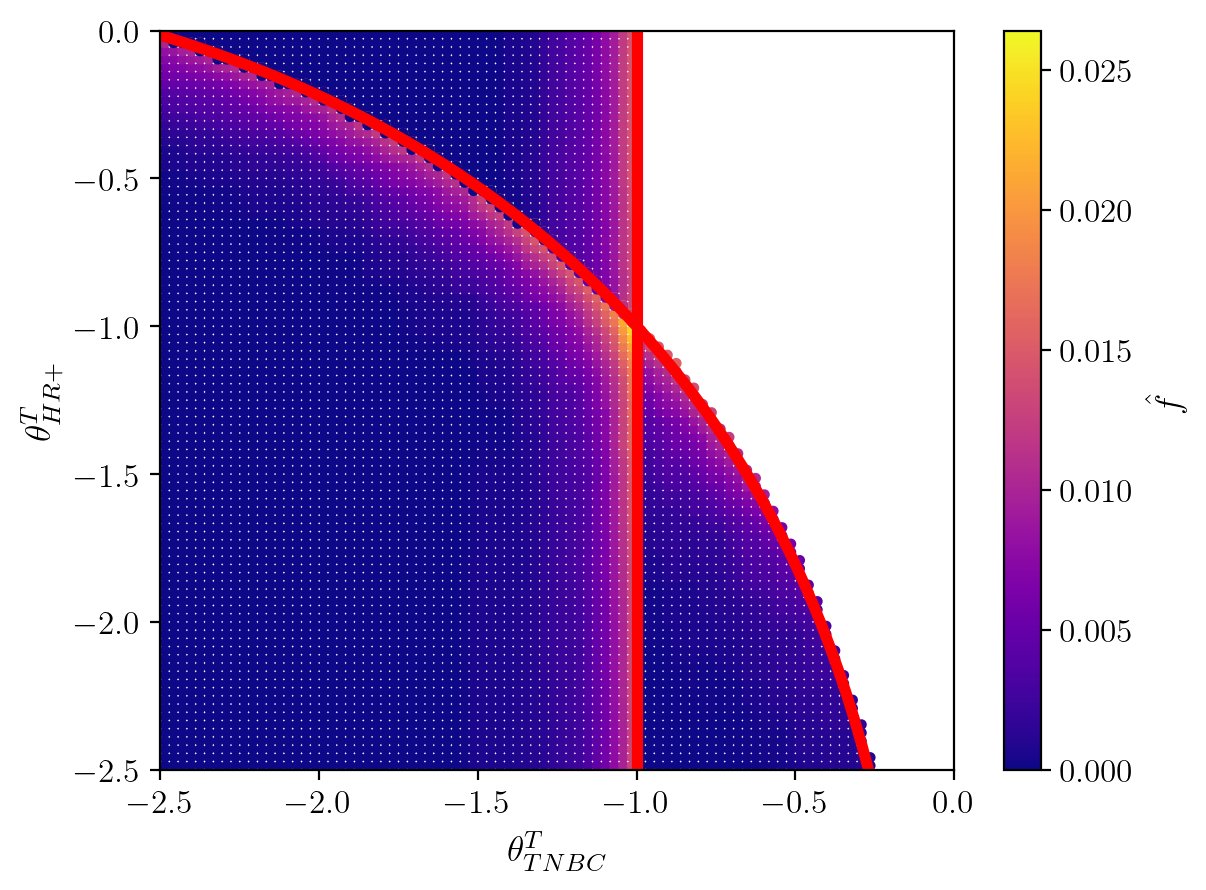

In [26]:
plt.scatter(theta[:,0], theta[:,1], c=val_df['tie_est'], s=8)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\hat{f}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.show()

In [22]:
cal_df = ip.calibrate(WD412D, g=grid, alpha=0.025, K=10000, model_kwargs={'ignore_intersection': True})

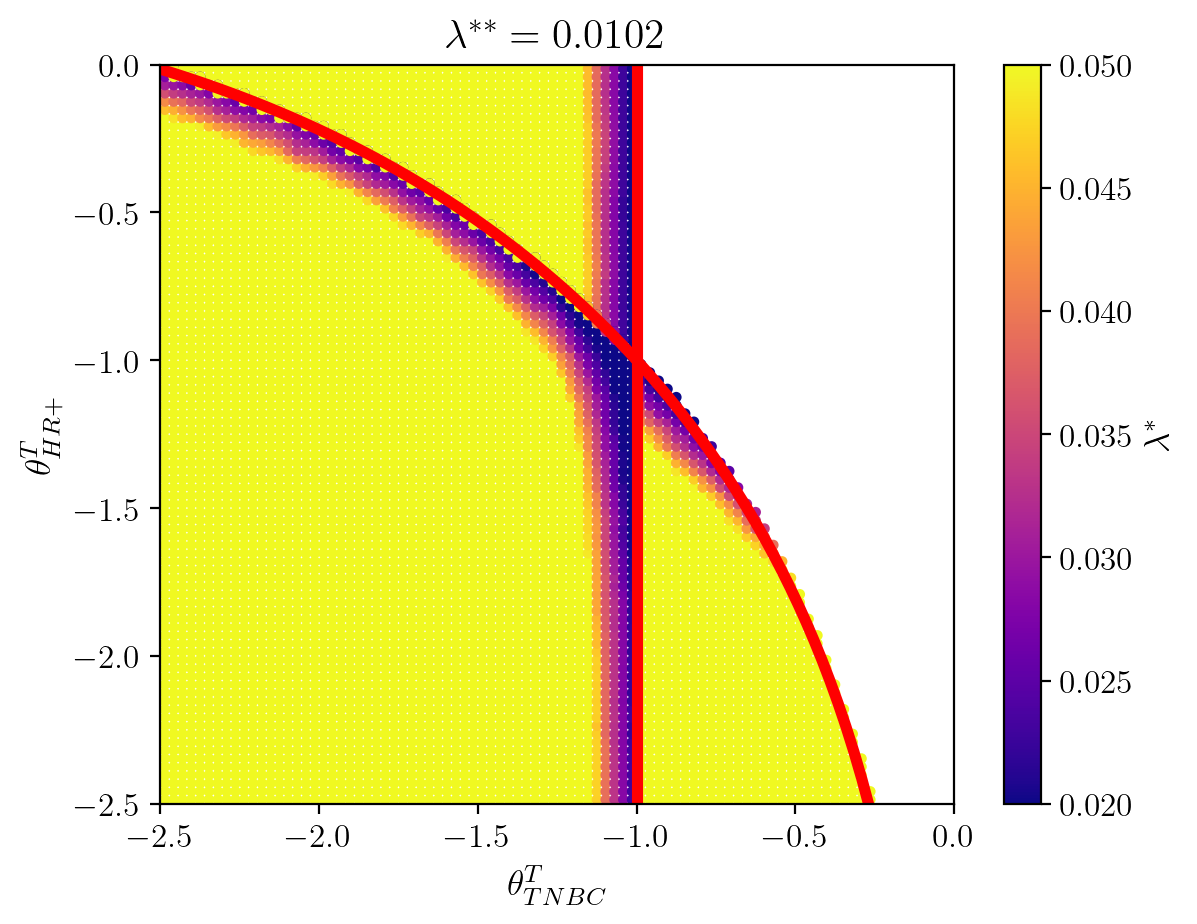

In [23]:
plt.scatter(theta[:,0], theta[:,1], c=cal_df['lams'], s=8, vmin=0.02, vmax=0.05)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\lambda^{*}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.title('$\lambda^{**}='+f'{cal_df["lams"].min():.4f}$')
plt.show()

## Bigger job

In [5]:
from confirm.adagrid import ada_calibrate

In [6]:
grid = ip.cartesian_grid(
    [-2.5, -2.5],
    [1.0, 1.0],
    n=[10, 10],
    null_hypos = nulls
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=100, worker_id=1, t=1677613827, n_bits=18, worker_bits=18) = [4604279914261381120 4604279914261381121 4604279914261381122, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=20, worker_id=1, t=1677613828, n_bits=18, worker_bits=18) = [4604279982980857856 4604279982980857857 4604279982980857858, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=30, worker_id=1, t=1677613829, n_bits=18, worker_bits=18) = [4604280051700334592 4604280051700334593 4604280051700334594, ...]:


In [9]:
db = ada_calibrate(
    WD412D,
    g=grid,
    alpha=0.025,
    bias_target=0.0005,
    grid_target=0.0005,
    std_target=0.0015,
    n_K_double=6,
    calibration_min_idx=80,
    step_size=2**13,
    packet_size=2**12,
    model_kwargs={'ignore_intersection': True}
)

DEBUG:confirm.adagrid.adagrid:first step (0, 0, 1, 69) n_tiles=69 packet_size=4096
DEBUG:confirm.adagrid.adagrid:Starting loop 0.
DEBUG:confirm.adagrid.adagrid:Claimed DB lock.
DEBUG:confirm.adagrid.adagrid:get_work(step_id=0, step_iter=0)
DEBUG:confirm.adagrid.adagrid:get_work(...) returned 69 tiles.
DEBUG:confirm.adagrid.adagrid:Processing 69 tiles.
DEBUG:confirm.adagrid.adagrid:{'n_processed': 69,
 'runtime_full_iter': '3.494257',
 'runtime_get_work': '0.001359',
 'runtime_processing': '3.467442',
 'runtime_update_step_info': '0.001626',
 'runtime_wait_for_lock': '0.000591',
 'status': 'WORK',
 'step_id': 0,
 'step_iter': 0,
 'step_n_iter': 1,
 'step_n_tiles': 69,
 'waitings': 0,
 'work_extraction_time': '1677613843.405244',
 'worker_id': 2,
 'worker_iter': 0}
DEBUG:confirm.adagrid.adagrid:Starting loop 0.
DEBUG:confirm.adagrid.adagrid:Claimed DB lock.
INFO:confirm.adagrid.calibration:[worker_id=2] 
Preparing new step with 69 parent tiles.
DEBUG:confirm.adagrid.db:[worker_id=2] 
fin

In [10]:
g_r = ip.grid.Grid(db.get_results(), None).prune_inactive()

In [11]:
g_r.n_tiles

128765

In [12]:
B_lams = np.array([g_r.df[f'B_lams{i}'].min() for i in range(50)])
lamss = g_r.df['lams'].min()
B_lams, lamss, B_lams.mean(), lamss - B_lams.mean()

(array([0.01415461, 0.01463434, 0.01374372, 0.01436333, 0.01422988, 0.01402769, 0.01409128,
        0.01462664, 0.01439797, 0.01452572, 0.01422988, 0.01422988, 0.01471439, 0.01465595,
        0.01438508, 0.01395343, 0.01439868, 0.01422987, 0.01453321, 0.01373493, 0.01375533,
        0.01438508, 0.01465595, 0.01404592, 0.01464996, 0.01422098, 0.01429261, 0.01462047,
        0.01414662, 0.01442387, 0.01424556, 0.01429829, 0.01422987, 0.01447258, 0.01438508,
        0.01464653, 0.01447258, 0.01404592, 0.01434448, 0.01365711, 0.01434448, 0.01422987,
        0.01409344, 0.01417179, 0.01451536, 0.01424556, 0.01422851, 0.01422987, 0.01422987,
        0.01438508], dtype=float32),
 0.014398683,
 0.014290583,
 0.00010809954)

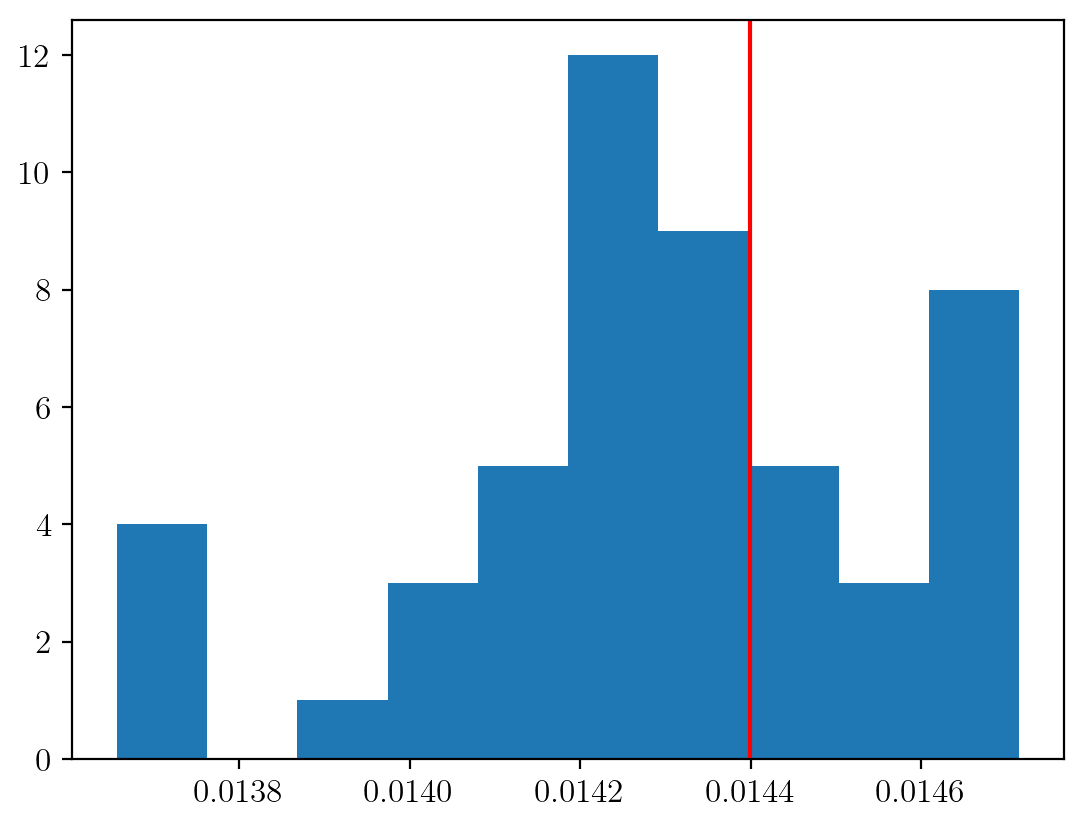

In [13]:

plt.hist(B_lams)
plt.axvline(lamss, color='r')
plt.show()

In [14]:
ordering = g_r.df['orderer'].sort_values()
ordering

100470    0.013712
92814     0.013712
108182    0.013712
108186    0.013712
108192    0.013712
            ...   
16093     0.907981
16096     0.907981
16095     0.908175
7395      0.908504
1614      0.910559
Name: orderer, Length: 128765, dtype: float64

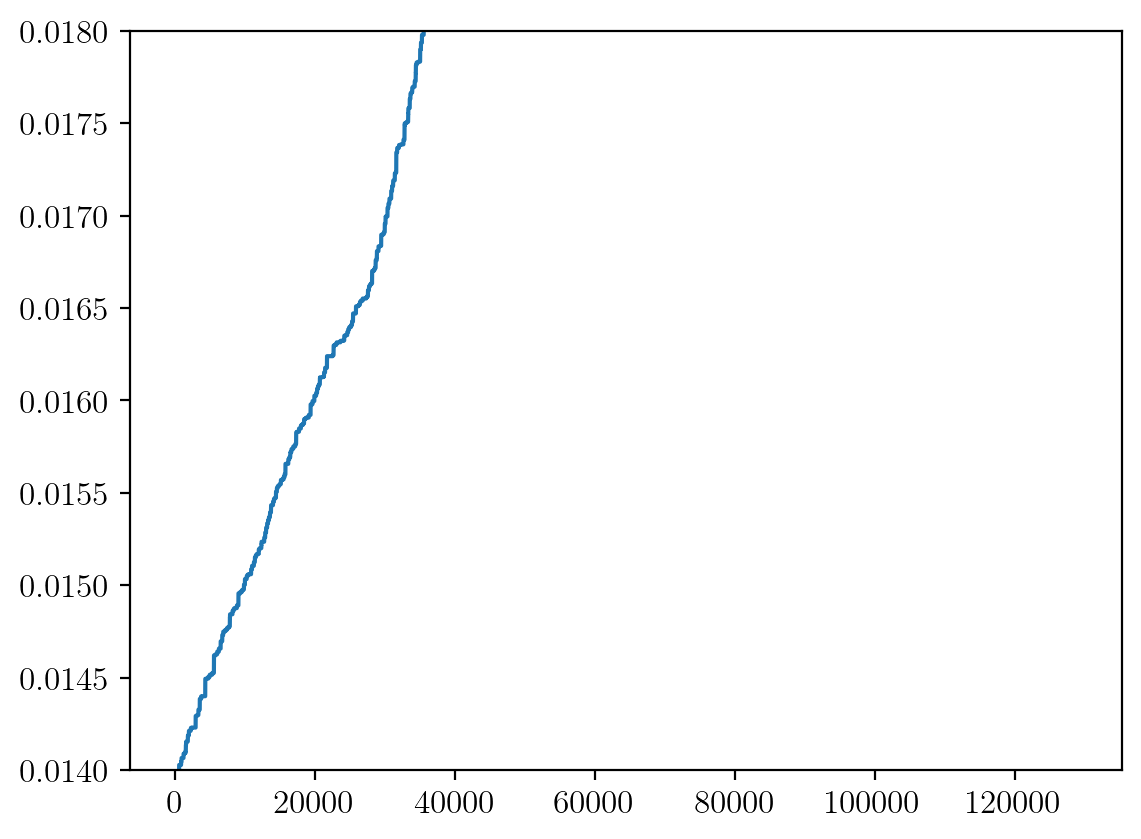

In [20]:
plt.plot(ordering.values)
plt.ylim([0.014, 0.018])
plt.show()

In [21]:
worst_tile = g_r.df.loc[g_r.df['lams'].idxmin()]
worst_tile[['theta0', 'theta1', 'radii0', 'radii1', 'orderer', "alpha0", 'K', 'lams']]

theta0    -1.001172
theta1    -0.997461
radii0     0.000391
radii1     0.001367
orderer    0.013712
alpha0     0.024625
K             65536
lams       0.014399
Name: 92814, dtype: object

In [17]:
np.searchsorted(ordering, worst_tile['orderer']), ordering.shape

(0, (128765,))

In [18]:
B_worst_tile = [g_r.df.loc[g_r.df[f'B_lams{i}'].idxmin()] for i in range(50)]
[(B_worst_tile[i]['orderer'], np.searchsorted(ordering, B_worst_tile[i]['orderer'])) for i in range(50)]

[(0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 

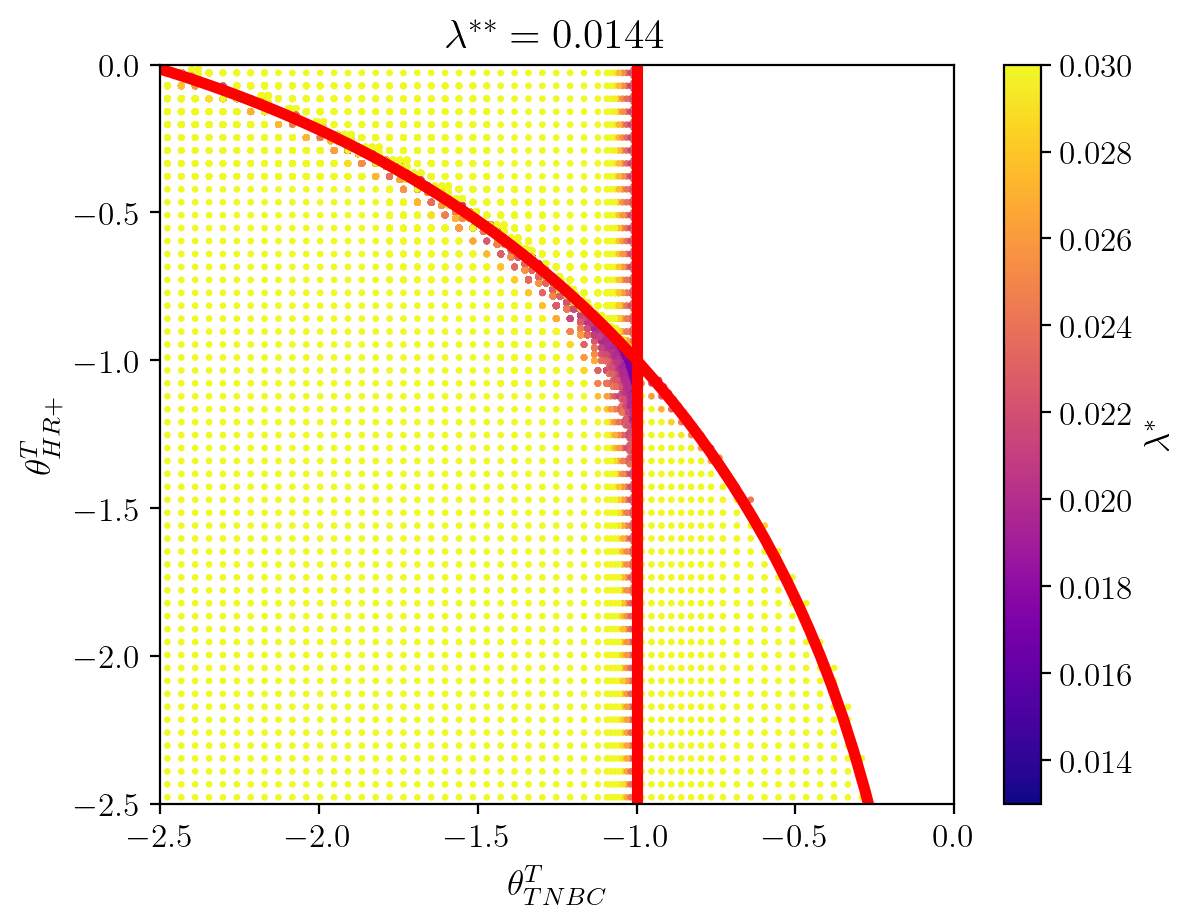

In [23]:
theta = g_r.get_theta()
p = expit(theta)
f = model.true_frac_tnbc
ptt = expit(np.linspace(-2.5, theta[:,1].max(), 100))
pht = ((p_tnbc_c * f + p_hrplus_c * (1 - f)) - (ptt * f)) / (1 - f)
plt.scatter(theta[:,0], theta[:,1], c=g_r.df['lams'], s=2, vmin=0.013, vmax=0.03)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\lambda^{*}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.title('$\lambda^{**}='+f'{lamss:.4f}$')
plt.show()

In [45]:
from jax.scipy.special import expit
results = jax.vmap(model.sim, in_axes=(0, None, None, None, None, None))(
    model.unifs[:1000], p_tnbc_c, expit(-1.0), p_hrplus_c, expit(1.0), True
)

lamss = 0.0239
import pandas as pd
df = pd.DataFrame(results)
df['rej_full'] = df['full_stat'] < lamss
df['rej_tnbc'] = df['tnbc_stat'] < lamss
df.head()

,HI_zcombined,full_stat,hypfull_zstat,hypofull_live,hypotnbc_live,hyptnbc_zstat,tnbc_stat,zfull_stage1,zfull_stage2,ztnbc_stage1,ztnbc_stage2,rej_full,rej_tnbc
0,1.677172,0.046754,1.882450,True,False,-1.309097,0.904749,2.161197,0.500988,-1.162869,-0.688474,False,False
1,3.309248,0.000468,3.496170,True,False,0.556655,0.288882,2.410580,2.533751,0.286446,0.500783,True,False
2,3.329800,0.000435,3.522123,True,False,0.332004,0.369943,2.332458,2.648576,0.723627,-0.254103,True,False
3,4.472816,0.000004,4.588161,True,False,0.832550,0.202549,4.098088,2.390551,1.463850,-0.286446,True,False
4,3.792567,0.000075,3.939487,True,False,-0.062377,0.524869,3.160696,2.410580,-0.324657,0.236442,True,False


In [46]:
df.loc[df['rej_tnbc']]

,HI_zcombined,full_stat,hypfull_zstat,hypofull_live,hypotnbc_live,hyptnbc_zstat,tnbc_stat,zfull_stage1,zfull_stage2,ztnbc_stage1,ztnbc_stage2,rej_full,rej_tnbc
38,4.930005,4.111376e-07,5.044601,True,False,2.680559,0.003675,4.132424,3.001720,1.951800,1.839083,True,True
183,4.616590,1.950487e-06,4.753480,True,False,2.279196,0.011328,3.415073,3.307364,1.313631,1.909640,True,True
244,5.784158,3.643824e-09,5.889882,True,False,2.478750,0.006592,4.488641,3.840910,2.003132,1.502349,True,True
292,5.603102,1.052749e-08,5.746051,True,False,2.382713,0.008593,3.257502,4.868642,1.366533,2.003132,True,True
317,6.534589,3.189220e-11,6.634014,True,False,2.265775,0.011733,4.821160,4.560752,1.549194,1.655096,True,True
374,5.952938,1.316859e-09,6.063214,True,False,2.202515,0.013814,4.286187,4.288493,1.729186,1.385641,True,True
395,5.517431,1.719954e-08,5.643636,True,False,2.017920,0.021800,3.728770,4.252536,0.788178,2.065591,True,True
454,6.419673,6.828360e-11,6.550988,True,False,2.708091,0.003384,3.572131,5.692366,0.487950,3.341870,True,True
482,5.922977,1.580822e-09,6.055137,True,False,2.500945,0.006193,3.547251,5.016005,2.223239,1.313631,True,True
501,4.566278,2.482299e-06,4.713284,True,False,2.099207,0.017899,3.158673,3.506918,1.655096,1.313631,True,True
